In [16]:
import os
import pandas as pd
import numpy as np

import zipfile
from urllib import request

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision import transforms

In [17]:
def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [18]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [19]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [20]:
class ArrayDataset(Dataset):

    def __init__(self, user, item, rating, transform=None):
        self.user = user
        self.item = item
        self.rating = rating
        self.transform = transform

    def __getitem__(self, idx):
        arr = np.column_stack((self.user, self.item, self.rating))
        if self.transform:
            arr = self.transform(arr)
        return torch.Tensor(arr[idx])

    def __len__(self):
        return len(self.user)

In [21]:
def collate_batch(batch):
    # print('fn', type(batch), len(batch), batch[0])
    # batch는 tensor가 batch size만큼 들어간 리스트
    batch = torch.stack(batch)
    return batch[:, 0], batch[:, 1], batch[:, 2]

In [22]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    # df load
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    # user, item, rating load
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    # u,i,r을 묶어서 해당 idx 반환
    train_set = ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    # u, i, r를 batch 단위의 tensor로 반환
    train_iter = DataLoader(
        train_set, shuffle=True,
        batch_size=batch_size, 
        collate_fn=collate_batch
        )
    test_iter = DataLoader(
        test_set, batch_size=batch_size, 
        collate_fn=collate_batch
        )
    return num_users, num_items, train_iter, test_iter

In [23]:
from torch import nn

class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

In [24]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, x, y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [25]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)


C:\Users\jiwoo\AppData\Local\Temp\ipykernel_23732\1723117690.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data, num_users, num_items = read_data_ml100k()


In [26]:
model = MF(30, num_users, num_items)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MF(
  (P): Embedding(943, 30)
  (Q): Embedding(1682, 30)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
)

In [27]:
lr, num_epochs, wd = 0.002, 50, 1e-5

loss_func = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [29]:
from tqdm import tqdm
import glob

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
  train_iter_loss = []
  for i, values in enumerate(train_iter):
    train_user = values[0].long().to(device)
    train_item = values[1].long().to(device)
    labels = values[2].to(device)
    preds = model(train_user, train_item)
    loss = loss_func(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iter_loss.append(loss.detach().item())
    if i%50 == 0:
      print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
  train_epoch_loss.append(np.mean(train_iter_loss))
  print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))
  
  with torch.no_grad():
    model.eval()
    val_epoch_loss = 0
    for i, values in enumerate(test_iter):
      test_user = values[0].long().to(device)
      test_item = values[1].long().to(device)
      labels = values[2].to(device)
      preds = model(test_user, test_item)
      loss = loss_func(preds, labels)
      val_epoch_loss += loss.detach().item()
  val_epoch_loss /= len(test_iter)
  val_epoch_loss_lst.append(val_epoch_loss)

  if val_epoch_loss < best_val_epoch_loss:
    best_val_epoch_loss = val_epoch_loss
    print(f'New best model loss: {best_val_epoch_loss}')
    if not os.path.exists('model'):
      os.mkdir('model')

    if os.path.exists('model/best.pth'):
      os.remove('model/best.pth')
    torch.save(model.state_dict(), 'model/best.pth')
    print('best model is saved!')
    

  0%|          | 0/50 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 4.54402494430542
0 epoch 50th train iter loss: 4.5856099128723145
0 epoch 100th train iter loss: 4.434781074523926
0 epoch 150th train iter loss: 4.177191734313965


  2%|▏         | 1/50 [01:02<50:58, 62.41s/it]

0 epoch ALL LOSS :  4.490264882746431
New best model loss: 5.038214206695557
best model is saved!
1 epoch 0th train iter loss: 4.173488140106201
1 epoch 50th train iter loss: 4.247422218322754
1 epoch 100th train iter loss: 3.8626585006713867
1 epoch 150th train iter loss: 3.90220046043396


  4%|▍         | 2/50 [02:01<48:11, 60.23s/it]

1 epoch ALL LOSS :  3.981402477038275
New best model loss: 4.698655366897583
best model is saved!
2 epoch 0th train iter loss: 3.555708646774292
2 epoch 50th train iter loss: 3.5759847164154053
2 epoch 100th train iter loss: 3.728524684906006
2 epoch 150th train iter loss: 3.4545109272003174


  6%|▌         | 3/50 [02:59<46:32, 59.41s/it]

2 epoch ALL LOSS :  3.5191502325313606
New best model loss: 4.384494781494141
best model is saved!
3 epoch 0th train iter loss: 3.434480667114258
3 epoch 50th train iter loss: 3.1367859840393066
3 epoch 100th train iter loss: 2.986981153488159
3 epoch 150th train iter loss: 2.9485366344451904


  8%|▊         | 4/50 [04:00<45:58, 59.97s/it]

3 epoch ALL LOSS :  3.10245052932464
New best model loss: 4.098475456237793
best model is saved!
4 epoch 0th train iter loss: 2.7220122814178467
4 epoch 50th train iter loss: 2.653718948364258
4 epoch 100th train iter loss: 2.6177051067352295
4 epoch 150th train iter loss: 2.5298616886138916


 10%|█         | 5/50 [05:01<45:21, 60.49s/it]

4 epoch ALL LOSS :  2.7293905781716417
New best model loss: 3.8400542736053467
best model is saved!
5 epoch 0th train iter loss: 2.421354055404663
5 epoch 50th train iter loss: 2.5602409839630127
5 epoch 100th train iter loss: 2.470212936401367
5 epoch 150th train iter loss: 2.3529083728790283


 12%|█▏        | 6/50 [06:14<47:28, 64.74s/it]

5 epoch ALL LOSS :  2.4021197360815463
New best model loss: 3.602642297744751
best model is saved!
6 epoch 0th train iter loss: 2.1670150756835938
6 epoch 50th train iter loss: 2.1424074172973633
6 epoch 100th train iter loss: 2.1480181217193604
6 epoch 150th train iter loss: 2.0162322521209717


 14%|█▍        | 7/50 [07:14<45:08, 63.00s/it]

6 epoch ALL LOSS :  2.119425908806398
New best model loss: 3.3954365253448486
best model is saved!
7 epoch 0th train iter loss: 1.989971399307251
7 epoch 50th train iter loss: 1.8438557386398315
7 epoch 100th train iter loss: 1.9309532642364502
7 epoch 150th train iter loss: 1.8599694967269897


 16%|█▌        | 8/50 [08:12<43:06, 61.59s/it]

7 epoch ALL LOSS :  1.8791464345971334
New best model loss: 3.2103925943374634
best model is saved!
8 epoch 0th train iter loss: 1.8212721347808838
8 epoch 50th train iter loss: 1.6984487771987915
8 epoch 100th train iter loss: 1.7360652685165405
8 epoch 150th train iter loss: 1.6809324026107788


 18%|█▊        | 9/50 [09:17<42:48, 62.64s/it]

8 epoch ALL LOSS :  1.6769934149132562
New best model loss: 3.0508185625076294
best model is saved!
9 epoch 0th train iter loss: 1.4417979717254639
9 epoch 50th train iter loss: 1.5394070148468018
9 epoch 100th train iter loss: 1.5725436210632324
9 epoch 150th train iter loss: 1.4931950569152832


 20%|██        | 10/50 [10:26<43:00, 64.51s/it]

9 epoch ALL LOSS :  1.51037858503381
New best model loss: 2.912554383277893
best model is saved!
10 epoch 0th train iter loss: 1.4509212970733643
10 epoch 50th train iter loss: 1.4181183576583862
10 epoch 100th train iter loss: 1.4289515018463135
10 epoch 150th train iter loss: 1.3760991096496582


 22%|██▏       | 11/50 [11:33<42:20, 65.15s/it]

10 epoch ALL LOSS :  1.3726089781092614
New best model loss: 2.7962067127227783
best model is saved!
11 epoch 0th train iter loss: 1.1680457592010498
11 epoch 50th train iter loss: 1.2101705074310303
11 epoch 100th train iter loss: 1.2766512632369995
11 epoch 150th train iter loss: 1.2336201667785645


 24%|██▍       | 12/50 [12:41<41:57, 66.25s/it]

11 epoch ALL LOSS :  1.2611833841530318
New best model loss: 2.6940921545028687
best model is saved!
12 epoch 0th train iter loss: 1.121359944343567
12 epoch 50th train iter loss: 1.1608624458312988
12 epoch 100th train iter loss: 1.1811795234680176
12 epoch 150th train iter loss: 1.1925997734069824


 26%|██▌       | 13/50 [13:53<41:57, 68.05s/it]

12 epoch ALL LOSS :  1.1700475381821702
New best model loss: 2.6093640327453613
best model is saved!
13 epoch 0th train iter loss: 1.0522236824035645
13 epoch 50th train iter loss: 1.0964914560317993
13 epoch 100th train iter loss: 1.0483355522155762
13 epoch 150th train iter loss: 1.2141120433807373


 28%|██▊       | 14/50 [14:59<40:16, 67.14s/it]

13 epoch ALL LOSS :  1.0957906774638855
New best model loss: 2.5359158515930176
best model is saved!
14 epoch 0th train iter loss: 1.0850342512130737
14 epoch 50th train iter loss: 1.0266374349594116
14 epoch 100th train iter loss: 1.0786982774734497
14 epoch 150th train iter loss: 1.018005609512329


 30%|███       | 15/50 [16:02<38:32, 66.07s/it]

14 epoch ALL LOSS :  1.0353266765776368
New best model loss: 2.4733153581619263
best model is saved!
15 epoch 0th train iter loss: 0.9696335792541504
15 epoch 50th train iter loss: 1.0097770690917969
15 epoch 100th train iter loss: 1.0336970090866089
15 epoch 150th train iter loss: 0.9845637679100037


 32%|███▏      | 16/50 [17:07<37:16, 65.77s/it]

15 epoch ALL LOSS :  0.986035102114235
New best model loss: 2.416628837585449
best model is saved!
16 epoch 0th train iter loss: 0.9181937575340271
16 epoch 50th train iter loss: 0.9294485449790955
16 epoch 100th train iter loss: 0.9557159543037415
16 epoch 150th train iter loss: 0.9224236607551575


 34%|███▍      | 17/50 [18:11<35:52, 65.22s/it]

16 epoch ALL LOSS :  0.9453226576760873
New best model loss: 2.3711947202682495
best model is saved!
17 epoch 0th train iter loss: 0.8862479329109192
17 epoch 50th train iter loss: 0.8818050622940063
17 epoch 100th train iter loss: 0.9077484011650085
17 epoch 150th train iter loss: 0.9761040210723877


 36%|███▌      | 18/50 [19:13<34:11, 64.10s/it]

17 epoch ALL LOSS :  0.9113633488256907
New best model loss: 2.3296470642089844
best model is saved!
18 epoch 0th train iter loss: 0.8470337986946106
18 epoch 50th train iter loss: 0.9165022373199463
18 epoch 100th train iter loss: 0.876227855682373
18 epoch 150th train iter loss: 0.8829486966133118


 38%|███▊      | 19/50 [20:03<31:02, 60.09s/it]

18 epoch ALL LOSS :  0.8831776079443312
New best model loss: 2.295838713645935
best model is saved!
19 epoch 0th train iter loss: 0.8660504221916199
19 epoch 50th train iter loss: 0.801274299621582
19 epoch 100th train iter loss: 0.8606547713279724
19 epoch 150th train iter loss: 0.903693675994873


 40%|████      | 20/50 [20:54<28:37, 57.24s/it]

19 epoch ALL LOSS :  0.8591439081835992
New best model loss: 2.262746572494507
best model is saved!
20 epoch 0th train iter loss: 0.8288955688476562
20 epoch 50th train iter loss: 0.8091239929199219
20 epoch 100th train iter loss: 0.8506553173065186
20 epoch 150th train iter loss: 0.8401538133621216


 42%|████▏     | 21/50 [21:44<26:41, 55.22s/it]

20 epoch ALL LOSS :  0.8387294909388748
New best model loss: 2.23592746257782
best model is saved!
21 epoch 0th train iter loss: 0.7702292203903198
21 epoch 50th train iter loss: 0.7984943985939026
21 epoch 100th train iter loss: 0.8320362567901611
21 epoch 150th train iter loss: 0.8437666296958923


 44%|████▍     | 22/50 [22:36<25:12, 54.01s/it]

21 epoch ALL LOSS :  0.8208101032320986
New best model loss: 2.2098888158798218
best model is saved!
22 epoch 0th train iter loss: 0.8089014887809753
22 epoch 50th train iter loss: 0.8277038931846619
22 epoch 100th train iter loss: 0.824716329574585
22 epoch 150th train iter loss: 0.7875254154205322


 46%|████▌     | 23/50 [23:25<23:40, 52.61s/it]

22 epoch ALL LOSS :  0.8051821908999964
New best model loss: 2.191047787666321
best model is saved!
23 epoch 0th train iter loss: 0.786371648311615
23 epoch 50th train iter loss: 0.7453399300575256
23 epoch 100th train iter loss: 0.7507498860359192
23 epoch 150th train iter loss: 0.8482711315155029


 48%|████▊     | 24/50 [24:17<22:43, 52.43s/it]

23 epoch ALL LOSS :  0.7907970971667889
New best model loss: 2.17036771774292
best model is saved!
24 epoch 0th train iter loss: 0.6824577450752258
24 epoch 50th train iter loss: 0.7729737758636475
24 epoch 100th train iter loss: 0.802119791507721
24 epoch 150th train iter loss: 0.7427480220794678


 50%|█████     | 25/50 [25:10<21:57, 52.70s/it]

24 epoch ALL LOSS :  0.7781438031761917
New best model loss: 2.154584527015686
best model is saved!
25 epoch 0th train iter loss: 0.7424487471580505
25 epoch 50th train iter loss: 0.7676519155502319
25 epoch 100th train iter loss: 0.7719866037368774
25 epoch 150th train iter loss: 0.826576828956604


 52%|█████▏    | 26/50 [26:00<20:40, 51.70s/it]

25 epoch ALL LOSS :  0.7666079601676193
New best model loss: 2.1388940811157227
best model is saved!
26 epoch 0th train iter loss: 0.7592803835868835
26 epoch 50th train iter loss: 0.7749331593513489
26 epoch 100th train iter loss: 0.7899979948997498
26 epoch 150th train iter loss: 0.8127316236495972


 54%|█████▍    | 27/50 [26:48<19:28, 50.82s/it]

26 epoch ALL LOSS :  0.7561168572337357
New best model loss: 2.12630832195282
best model is saved!
27 epoch 0th train iter loss: 0.7268146276473999
27 epoch 50th train iter loss: 0.7433276176452637
27 epoch 100th train iter loss: 0.7773835062980652
27 epoch 150th train iter loss: 0.7800657749176025


 56%|█████▌    | 28/50 [27:31<17:41, 48.27s/it]

27 epoch ALL LOSS :  0.7463950143032467
New best model loss: 2.1156959533691406
best model is saved!
28 epoch 0th train iter loss: 0.6950313448905945
28 epoch 50th train iter loss: 0.7623844742774963
28 epoch 100th train iter loss: 0.7363076210021973
28 epoch 150th train iter loss: 0.7311348915100098


 58%|█████▊    | 29/50 [28:08<15:45, 45.01s/it]

28 epoch ALL LOSS :  0.7371091612221039
New best model loss: 2.105574131011963
best model is saved!
29 epoch 0th train iter loss: 0.6953928470611572
29 epoch 50th train iter loss: 0.7432392239570618
29 epoch 100th train iter loss: 0.6768046617507935
29 epoch 150th train iter loss: 0.7538062930107117


 60%|██████    | 30/50 [28:46<14:16, 42.85s/it]

29 epoch ALL LOSS :  0.7283789306571803
New best model loss: 2.0938119888305664
best model is saved!
30 epoch 0th train iter loss: 0.6909561157226562
30 epoch 50th train iter loss: 0.6920982599258423
30 epoch 100th train iter loss: 0.7521802186965942
30 epoch 150th train iter loss: 0.7716395854949951


 62%|██████▏   | 31/50 [29:23<13:03, 41.22s/it]

30 epoch ALL LOSS :  0.7205178215331638
New best model loss: 2.0869868993759155
best model is saved!
31 epoch 0th train iter loss: 0.7009055614471436
31 epoch 50th train iter loss: 0.7109072208404541
31 epoch 100th train iter loss: 0.6884382963180542
31 epoch 150th train iter loss: 0.6879075169563293


 64%|██████▍   | 32/50 [30:01<12:03, 40.18s/it]

31 epoch ALL LOSS :  0.7126113280807573
New best model loss: 2.0791949033737183
best model is saved!
32 epoch 0th train iter loss: 0.7100490927696228
32 epoch 50th train iter loss: 0.7012973427772522
32 epoch 100th train iter loss: 0.6898794770240784
32 epoch 150th train iter loss: 0.7091200351715088


 66%|██████▌   | 33/50 [30:40<11:17, 39.85s/it]

32 epoch ALL LOSS :  0.7053748258610362
New best model loss: 2.074686288833618
best model is saved!
33 epoch 0th train iter loss: 0.7080491781234741
33 epoch 50th train iter loss: 0.6973591446876526
33 epoch 100th train iter loss: 0.7406437397003174
33 epoch 150th train iter loss: 0.7086543440818787


 68%|██████▊   | 34/50 [31:21<10:40, 40.06s/it]

33 epoch ALL LOSS :  0.6984665532087543
New best model loss: 2.0692392587661743
best model is saved!
34 epoch 0th train iter loss: 0.6698135137557983
34 epoch 50th train iter loss: 0.6943762898445129
34 epoch 100th train iter loss: 0.6946685314178467
34 epoch 150th train iter loss: 0.7392078638076782


 70%|███████   | 35/50 [31:59<09:51, 39.45s/it]

34 epoch ALL LOSS :  0.6917552321227556
New best model loss: 2.0665539503097534
best model is saved!
35 epoch 0th train iter loss: 0.7035092115402222
35 epoch 50th train iter loss: 0.678926944732666
35 epoch 100th train iter loss: 0.7278624176979065
35 epoch 150th train iter loss: 0.7194337248802185


 72%|███████▏  | 36/50 [32:39<09:15, 39.67s/it]

35 epoch ALL LOSS :  0.6851848210256124
New best model loss: 2.059429347515106
best model is saved!
36 epoch 0th train iter loss: 0.6668899655342102
36 epoch 50th train iter loss: 0.6352882981300354
36 epoch 100th train iter loss: 0.6791310906410217
36 epoch 150th train iter loss: 0.676979660987854


 74%|███████▍  | 37/50 [33:18<08:33, 39.47s/it]

36 epoch ALL LOSS :  0.6792129155286809
New best model loss: 2.0589153170585632
best model is saved!
37 epoch 0th train iter loss: 0.6603817343711853
37 epoch 50th train iter loss: 0.6252197027206421
37 epoch 100th train iter loss: 0.6848349571228027
37 epoch 150th train iter loss: 0.7033218145370483


 76%|███████▌  | 38/50 [33:59<08:00, 40.06s/it]

37 epoch ALL LOSS :  0.673304411553845
New best model loss: 2.0546631813049316
best model is saved!
38 epoch 0th train iter loss: 0.6414810419082642
38 epoch 50th train iter loss: 0.6698529720306396
38 epoch 100th train iter loss: 0.6876908540725708
38 epoch 150th train iter loss: 0.6741138696670532


 78%|███████▊  | 39/50 [34:37<07:13, 39.43s/it]

38 epoch ALL LOSS :  0.6677336268818256
New best model loss: 2.0537915229797363
best model is saved!
39 epoch 0th train iter loss: 0.652863621711731
39 epoch 50th train iter loss: 0.6700704097747803
39 epoch 100th train iter loss: 0.647173285484314
39 epoch 150th train iter loss: 0.6284986734390259


 80%|████████  | 40/50 [35:16<06:32, 39.24s/it]

39 epoch ALL LOSS :  0.6621100410972673
New best model loss: 2.0495548844337463
best model is saved!
40 epoch 0th train iter loss: 0.6424343585968018
40 epoch 50th train iter loss: 0.6739658117294312
40 epoch 100th train iter loss: 0.6258007884025574
40 epoch 150th train iter loss: 0.6807909607887268


 82%|████████▏ | 41/50 [35:58<05:59, 39.90s/it]

40 epoch ALL LOSS :  0.6569634420970052
41 epoch 0th train iter loss: 0.6041609048843384
41 epoch 50th train iter loss: 0.6080808639526367
41 epoch 100th train iter loss: 0.6496347188949585
41 epoch 150th train iter loss: 0.6604554057121277


 84%|████████▍ | 42/50 [36:35<05:14, 39.27s/it]

41 epoch ALL LOSS :  0.651877200480589
42 epoch 0th train iter loss: 0.6391979455947876
42 epoch 50th train iter loss: 0.6227146983146667
42 epoch 100th train iter loss: 0.6365312933921814
42 epoch 150th train iter loss: 0.6396224498748779


 86%|████████▌ | 43/50 [37:13<04:31, 38.77s/it]

42 epoch ALL LOSS :  0.647050949408836
New best model loss: 2.0481072664260864
best model is saved!
43 epoch 0th train iter loss: 0.6191657185554504
43 epoch 50th train iter loss: 0.6386541724205017
43 epoch 100th train iter loss: 0.6455228328704834
43 epoch 150th train iter loss: 0.6566659808158875


 88%|████████▊ | 44/50 [37:52<03:52, 38.70s/it]

43 epoch ALL LOSS :  0.6421878651245353
New best model loss: 2.047210693359375
best model is saved!
44 epoch 0th train iter loss: 0.6002344489097595
44 epoch 50th train iter loss: 0.6616236567497253
44 epoch 100th train iter loss: 0.65774005651474
44 epoch 150th train iter loss: 0.6876069903373718


 90%|█████████ | 45/50 [38:29<03:11, 38.36s/it]

44 epoch ALL LOSS :  0.6376671308709174
New best model loss: 2.046666979789734
best model is saved!
45 epoch 0th train iter loss: 0.5949679017066956
45 epoch 50th train iter loss: 0.6117112636566162
45 epoch 100th train iter loss: 0.6251301765441895
45 epoch 150th train iter loss: 0.6313714385032654


 92%|█████████▏| 46/50 [39:07<02:32, 38.11s/it]

45 epoch ALL LOSS :  0.6334010500883319
New best model loss: 2.045440435409546
best model is saved!
46 epoch 0th train iter loss: 0.5894468426704407
46 epoch 50th train iter loss: 0.6268550753593445
46 epoch 100th train iter loss: 0.6472891569137573
46 epoch 150th train iter loss: 0.6093910932540894


 94%|█████████▍| 47/50 [39:46<01:55, 38.56s/it]

46 epoch ALL LOSS :  0.6290035521246723
New best model loss: 2.044510066509247
best model is saved!
47 epoch 0th train iter loss: 0.5983342528343201
47 epoch 50th train iter loss: 0.6307503581047058
47 epoch 100th train iter loss: 0.6179786920547485
47 epoch 150th train iter loss: 0.634006142616272


 96%|█████████▌| 48/50 [40:25<01:17, 38.67s/it]

47 epoch ALL LOSS :  0.6248256631733216
New best model loss: 2.042339861392975
best model is saved!
48 epoch 0th train iter loss: 0.5981984734535217
48 epoch 50th train iter loss: 0.5744401216506958
48 epoch 100th train iter loss: 0.6297907829284668
48 epoch 150th train iter loss: 0.6219444870948792


 98%|█████████▊| 49/50 [41:03<00:38, 38.29s/it]

48 epoch ALL LOSS :  0.620638402159681
49 epoch 0th train iter loss: 0.6576353907585144
49 epoch 50th train iter loss: 0.6480218172073364
49 epoch 100th train iter loss: 0.6115589737892151
49 epoch 150th train iter loss: 0.5874990820884705


100%|██████████| 50/50 [41:48<00:00, 50.16s/it]

49 epoch ALL LOSS :  0.6171384588959291
New best model loss: 2.040631353855133
best model is saved!


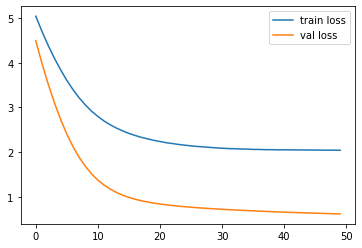

In [37]:
import matplotlib.pyplot as plt

plt.plot(val_epoch_loss_lst, label='train loss')

plt.plot(train_epoch_loss, label='val loss')
plt.legend()

In [35]:
scores = model(torch.tensor([20]).to(device), torch.tensor([20]).to(device))
scores

tensor([2.4434], device='cuda:0', grad_fn=<AddBackward0>)